In [ ]:
!pip install pandas numpy matplotlib scikit-learn tensorflow


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - loss: 0.1845 - val_loss: 0.3094
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1342 - val_loss: 0.1899
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0747 - val_loss: 0.0310
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0144 - val_loss: 0.0213
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0129 - val_loss: 0.0289
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0146 - val_loss: 0.0198
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0110 - val_loss: 0.0197
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0106 - val_loss: 0.0200
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0112 - val_loss: 0.0197
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0113 - val_loss: 0.0197
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - val_loss: 0.0197
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0091 - val_loss: 0.0207
Epoch 13/50

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Train RMSE: 5.56
Test RMSE: 7.86


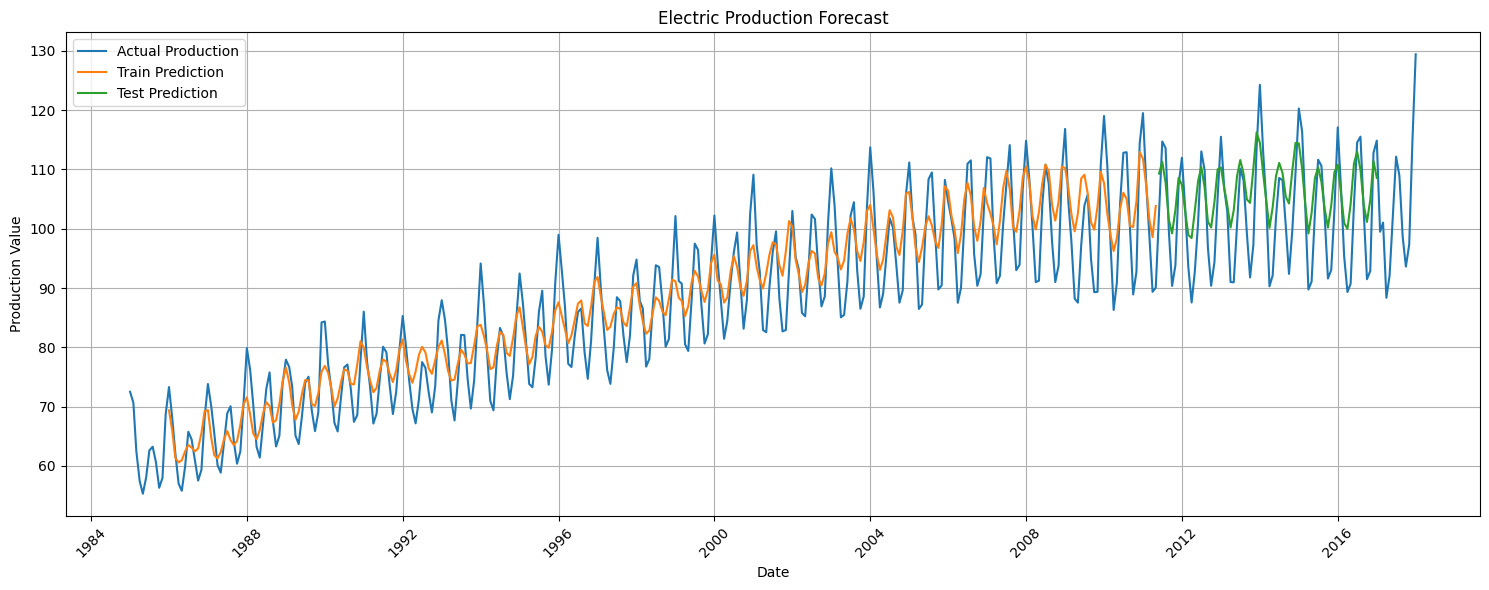

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step

Predicted electric production for 2018-01-31: 103.64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Load and prepare the data
def load_electric_data():
    df = pd.read_csv('Electric_Production.csv')
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)
    df = df.rename(columns={'IPG2211A2N': 'Production'})  # Rename column for clarity
    return df

# Create sequences for univariate time series
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def build_and_train_electric_model():
    # Load data
    df = load_electric_data()

    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Parameters
    sequence_length = 12  # Use 12 months (1 year) for seasonal patterns
    train_size = int(len(scaled_data) * 0.8)

    # Split into train and test
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    # Create sequences
    X_train, y_train = create_sequences(train_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)

    # Build LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
        LSTM(25, activation='relu'),
        Dense(1)  # Single output for production value
    ])

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Train model
    history = model.fit(X_train, y_train,
                       epochs=50,
                       batch_size=32,
                       validation_split=0.1,
                       verbose=1)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Inverse transform predictions
    train_predict = scaler.inverse_transform(train_predict)
    y_train_inv = scaler.inverse_transform(y_train)
    test_predict = scaler.inverse_transform(test_predict)
    y_test_inv = scaler.inverse_transform(y_test)

    # Calculate RMSE
    train_rmse = np.sqrt(np.mean((train_predict - y_train_inv)**2))
    test_rmse = np.sqrt(np.mean((test_predict - y_test_inv)**2))
    print(f'Train RMSE: {train_rmse:.2f}')
    print(f'Test RMSE: {test_rmse:.2f}')

    # Plot results
    plt.figure(figsize=(15, 6))

    # Original data
    plt.plot(df.index, df['Production'], label='Actual Production')

    # Training predictions
    train_plot = np.empty(len(df))
    train_plot[:] = np.nan
    train_plot[sequence_length:len(train_predict) + sequence_length] = train_predict.flatten()
    plt.plot(df.index, train_plot, label='Train Prediction')

    # Testing predictions
    test_plot = np.empty(len(df))
    test_plot[:] = np.nan
    test_plot[len(train_predict) + sequence_length:len(train_predict) + sequence_length + len(test_predict)] = test_predict.flatten()
    plt.plot(df.index, test_plot, label='Test Prediction')

    plt.title('Electric Production Forecast')
    plt.xlabel('Date')
    plt.ylabel('Production Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, scaler, df, sequence_length

# Function to predict next month's production
def predict_next_month(model, scaler, last_sequence):
    last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1))
    next_pred_scaled = model.predict(last_sequence_scaled.reshape(1, sequence_length, 1))
    next_pred = scaler.inverse_transform(next_pred_scaled)
    return next_pred[0][0]

if __name__ == "__main__":
    # Train the model
    model, scaler, df, sequence_length = build_and_train_electric_model()

    # Predict next month's production
    last_sequence = df.tail(sequence_length).values
    next_month_pred = predict_next_month(model, scaler, last_sequence)

    # Get last date and predict next month
    last_date = df.index[-1]
    next_date = last_date + pd.offsets.MonthEnd(1)

    print(f"\nPredicted electric production for {next_date.strftime('%Y-%m-%d')}: {next_month_pred:.2f}")